# Identifying Exoplanets from the Kepler Objects of Interest Dataset
***Matt Paterson, hello@hireMattPaterson.com***<br>
**Data Science Fellow, General Assembly, DSI-12, 2020**<br>
https://hireMattPaterson.com


## The Data Science Problem:
***Can we compare the data of currently unconfirmed Kepler Objects of Interest to that of Confirmed Exoplanets and Confirmed non-exoplanet observations to predict the existence of planets orbiting nearby stars?***

***Further, can we package this identification system to allow us to make the same, faster predictions on data in the K2 and TESS missions?***

***Positive results could save considerable amounts of money on research and allow those scientists to focus on more complexing questions about our celestial neighborhood.***

### The Project
The Kepler Mission ran from 2009 until 2013-2014 before the Kepler Telescope had a structural compromise that caused NASA to end the original mission. Since the telescope was pointed at one specific part of the sky, at one single constellation in order to find possible earth-sized planets in distances from their parent stars that could be hospitible to life, amongst thousands of stars, the inability to fully reposition the telescope as needed changed the scope of what could be accomplished by the mission. Thus, the K2 mission was born and from 2014-2018, Kepler continued to provide data on possible exoplanets to NASA and CalTech Scientists.

Here, we take the Cumulative Kepler Objects of Interest (KOI) dataset, train three seperate Machine Learning Models on over six thousand of the observations, with a baseline imbalance of about 35% Exoplanets and 65% KOI's that are certified to be not exoplanets, and then run predictions on 2,245 KOI's that are classified as 'Candidates'. In other words, we are using the work that NASA and CalTech has done over the past decade and letting three seperate computer algorithms process that data and predict which of the remaining unknown observations are indeed exoplanets. The answer is about 600.  Here's how we get there:



### The notebook and data
This notebook uses a python library that I created called lebowski that is used for exploratory data analysis and building machine learning models, and is included in this git repo.

This notebook reads in a ready-to-run dataset built in the notebook <a href='http://localhost:8888/notebooks/GeneralAssembly/Projects/exoplanet_alpha_models/code/EDA/BinaryClassExoplanets.ipynb'>BinaryClassExoplanets.ipynb</a> (also found in this repo in code/EDA/ ) and built from NASA's Kepler Objects of Interest dataset which is uploaded to this github repo and exists in the data folder, but is also available at its source at https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative where it can be downloaded as a CSV. 

In this notebook we take the readied data, after dropping out about 100 rows full of null values and slimming down to 42 columns.

It should be noted that the baseline models are pretty accurate already, likely due to the hard work of the researchers that built the datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import lebowski, my custom Python Library for EDA
import lebowski as dude
# import autoreload in case I create new lebowski funcitons
import autoreload  

# Libraries needed for Logistic Regression and RandomForestClassifier

from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import RandomForestClassifier
from sklearn.model_selection     import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing       import StandardScaler
from sklearn                     import metrics
from sklearn.metrics             import plot_confusion_matrix

# Libraries needed for Recurrent Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam

In [2]:
present_color = 'black'  # Sets the font color in all Matplotlib or Seaborn graphs to follow
                         # Use this function anytime you need to change font color

In [3]:
path_to_home = '../'                 # Sets the path to the 'home' directory in this package
datapath = path_to_home + 'data/'    # Creates the datapath for this directory

In [4]:
df = pd.read_csv(datapath + 'dirty_kepler.csv')
df.head()

,kepid,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,12168280,2,0,0,0,0,229.957537,0.006730,-0.006730,326.01840,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
1,11923074,0,0,0,0,1,1.756471,0.000015,-0.000015,132.02757,...,-157.0,4.561,0.033,-0.176,0.833,0.227,-0.071,296.14072,50.279949,14.723
2,11867733,0,0,1,0,0,384.356448,0.003680,-0.003680,298.90354,...,-193.0,4.445,0.067,-0.202,0.994,0.291,-0.125,293.77362,50.124470,14.391
3,10585887,0,1,0,0,0,378.654840,0.022800,-0.022800,288.25840,...,-209.0,4.463,0.070,-0.210,0.970,0.306,-0.123,285.24338,47.812592,14.872
4,10532751,0,1,0,0,0,367.761848,0.006750,-0.006750,194.76970,...,-295.0,2.897,0.045,-0.014,9.888,0.257,-2.058,290.87155,47.753368,10.736


## Do the flags indicate the planet's disposition?

**We know that this subset of data was a 'quick and dirty' creation set up to quantify all fields. Take some time to evaluate the data and make sure that all features are necessary to train our models**

Recall that koi_disposition equals 0 for 'Fals Positive', or not an exoplanet, 1 for 'Confirmed' as an exoplanet, or 2 for 'Candidate'. We want to eliminate columns in the dataset that will be harmful to prediction and create columns that might prove more helpful.

What do the four flag columns say about the kisposition column?


In [5]:
flags = ['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

In [6]:
df[flags].groupby('koi_disposition').sum()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,,,,
0,1135,2106,1779,1093
1,466,14,0,0
2,1,2,0,0


We see that the majority of the observations that contain flags have been deemed to not be exoplanets. Only 3 of 2245 observations that are still candidates have any flags at all.

## Identify the baseline imbalance in the data

In [7]:
df['koi_disposition'].value_counts()

0    4214
1    2285
2    2245
Name: koi_disposition, dtype: int64

We have about half of our data rows certified to be not exoplanets, about 25% are Confirmed exoplanets, and the remaining are unknown. Since the flags tell us pretty glaringly that certain objects are not planets, we should probably not use these columns to train our models. 

Here's a table to demonstrate that correlation between the flags and disposition:

In [8]:
df[flags].corr()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,1.000000,-0.021399,-0.523012,-0.472108,-0.353074
koi_fpflag_nt,-0.021399,1.000000,-0.020494,-0.002847,0.002204
koi_fpflag_ss,-0.523012,-0.020494,1.000000,0.145303,0.088528
koi_fpflag_co,-0.472108,-0.002847,0.145303,1.000000,0.531398
koi_fpflag_ec,-0.353074,0.002204,0.088528,0.531398,1.000000


The above table shows the correlation between each flag and the koi_disposition...and each other. Below we can see a heatmap visualization of the same.

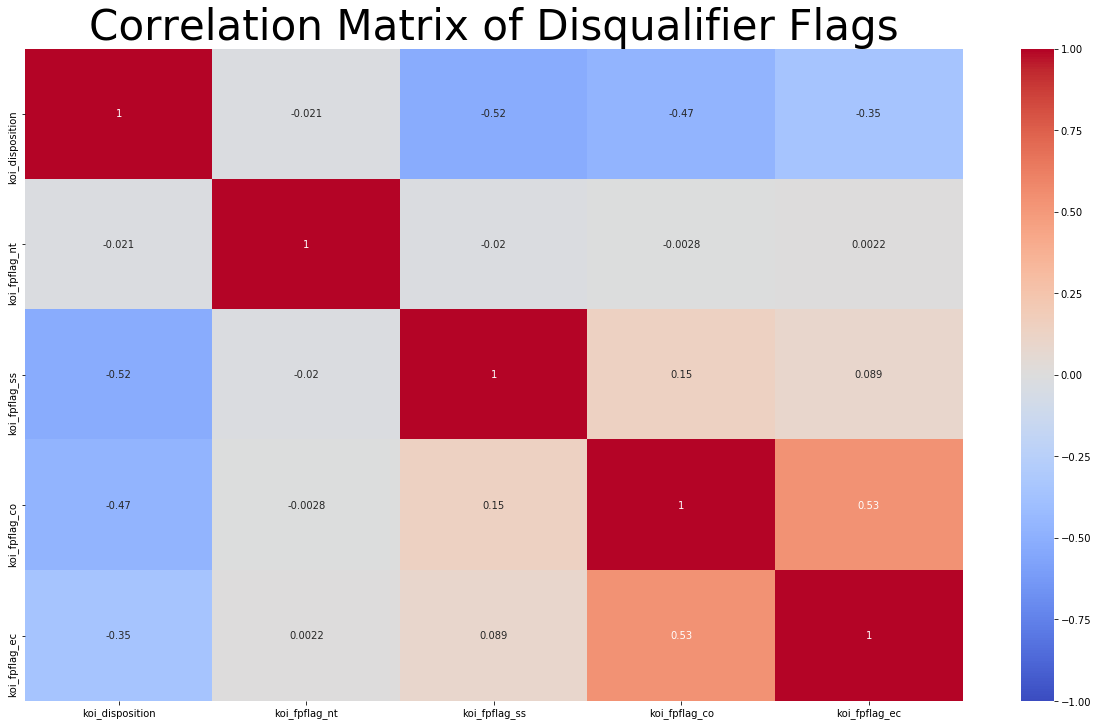

In [10]:
dude.graph_words(present_color)
dude.heatmap_this(df=df, features=flags, title="", word_color='black')
plt.title('Correlation Matrix of Disqualifier Flags', fontsize=42);

Here we can see a fairly strong positive correlation between koi_fpflag_co and koi_fpflag_ec, and an equally strong negative correlation between koi_fpflag_ss and koi_disposition.

_co and _ec stand for Centroid Offset Flag and Ephemeris Match Indicates Contamination Flag respectively.

_ss stands for Stellar Eclipse Flag.

The Stellar Eclipse Flag is set for observations that have been deemed to have been caused by some sort of eclipse of the star that is most likely caused by another star.  This is why the negative correlation is so strong, because it is a column marked by the researchers to weed out false positives in their initial candidate field.

The other two are indicators of anomalies in the data resulting from errors in the technology.

To conclude, we'll delete all of the flag columns becuase they are used by the researchers that compiled this dataset to idicate whether or not they had found the expolanets. They are instructive to us to see why each observation was labled, but will not help our algorithm to label future data that have zero's in these fields.

In [11]:
flags.remove('koi_disposition')

In [12]:
df = df.drop(columns=flags)

In [13]:
df.shape

(8744, 38)

We will also change the index of the table to the kepid so that when we make our predictions, we can submit the Kepler Identification Numbers for review...and maybe name a planet!

In [14]:
df.set_index('kepid', inplace=True)

## Create a Candidates DataFrame
In order to review and make predictions, we'll split off our unknown data from the certified and classified data.

In [15]:

candidates = df[df['koi_disposition'] == 2]
candidates.head()

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepid,,,,,,,,,,,,,,,,,,,,,
12168280,2,229.957537,0.006730,-0.006730,326.01840,0.01510,-0.01510,1.175,74.310,-4.203,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
9592621,2,191.037280,0.013200,-0.013200,153.91070,0.06480,-0.06480,0.091,0.456,-0.091,...,-180.0,4.497,0.055,-0.165,0.901,0.213,-0.091,293.68390,46.265541,16.652
9159288,2,66.673050,0.012400,-0.012400,161.59000,0.17600,-0.17600,0.415,0.049,-0.415,...,-256.0,4.369,0.072,-0.217,1.190,0.404,-0.135,293.68979,45.549332,14.634
9011955,2,367.089600,0.022800,-0.022800,178.67440,0.04220,-0.04220,1.242,72.990,-3.631,...,-260.0,4.429,0.058,-0.232,1.100,0.384,-0.128,287.86737,45.321289,15.267
8673511,2,0.757261,0.000004,-0.000004,131.62154,0.00472,-0.00472,0.322,0.190,-0.321,...,-171.0,4.479,0.062,-0.200,0.953,0.279,-0.093,284.29565,44.895859,14.024


## Remake our DataFrame to only include certified observations
We'll split up the data into a training and testing set from this binary classfied DataFrame

In [16]:
df = df[df['koi_disposition'] != 2] 

## Are there any strong correlations?
Shown below is a heatmap showing the correlations between each of the remaining features in our DataFrame

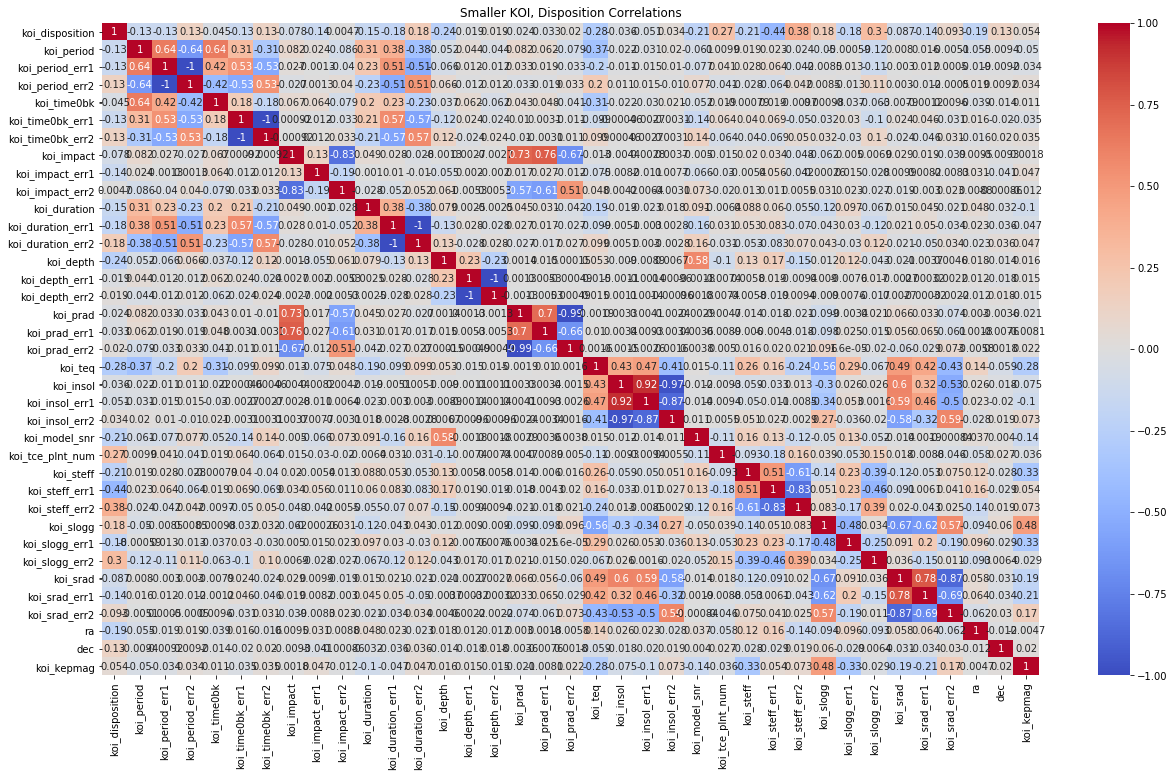

In [17]:
dude.heatmap_this(df, df.columns, 'Smaller KOI, Disposition Correlations')

## We don't have any strong correlations
**Let's get a new baseline Logistic Regression Model before we start adjusting columns**

In [18]:
# Instantiate a Logistic Regression Model Object
lr = LogisticRegression()
# Split and scale our data using the lebowski library
# --This function calls the train_test_split and also 
# --uses the StandardScaler to scale our numeric data
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(df, 'koi_disposition')

# Fit the model using our training data
lr.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
lr.score(X_train_sc, y_train)  # Accuracy of our predictions on the Training Set

0.9217157145604924

In [20]:
lr.score(X_val_sc, y_val)      # Accuracy of our predictions on the Validation Set

0.9207692307692308

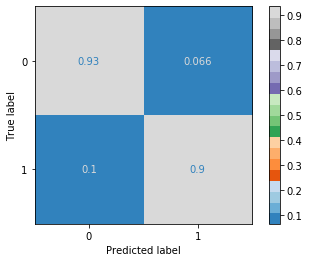

In [21]:
plot_confusion_matrix(lr, X_val_sc, y_val, normalize='true', cmap='tab20c');

Our simple Logistic Regression model has a baseline of 92% accuracy with about 10% false positives (that is objects our model predicts to be exoplanets but are actullay known to not be exoplanets, not to be confused with the KOI disposition of 'false positive'). That's pretty good, considering our sample has a split of 35% known exoplanets versus 65% known non-exoplanet observations.

Now let's mess with our datasets and try some more models.

## Since there are no strong correlations, let's look at the strongest correlations

In [22]:
# Print the ten strongest positive correlations
# start at index 1, because otherwise we'd include our target
df.corr()['koi_disposition'].sort_values(ascending=False)[1:11]

koi_steff_err2       0.383221
koi_slogg_err2       0.299148
koi_tce_plnt_num     0.273228
koi_duration_err2    0.184021
koi_slogg            0.176609
koi_period_err2      0.133796
koi_time0bk_err2     0.132515
dec                  0.128170
koi_srad_err2        0.092855
koi_kepmag           0.054105
Name: koi_disposition, dtype: float64

In [24]:
# Print the ten strongest negative correlations
df.corr()['koi_disposition'].sort_values(ascending=True)[0:10]

koi_steff_err1      -0.444002
koi_teq             -0.280370
koi_depth           -0.237222
koi_steff           -0.214034
koi_model_snr       -0.208750
ra                  -0.189946
koi_duration_err1   -0.184021
koi_slogg_err1      -0.181628
koi_duration        -0.150347
koi_impact_err1     -0.138214
Name: koi_disposition, dtype: float64

Above we see the top ten most positively and ten most negatively correlated columns from the KOI dataset as they relate to the koi_disposition.  Take some time to really familiarize yourself with each column as it is shown in the data dictionary, found here:  https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

The koi_steff_err2 is the negative poriton of the uncertainty of the photospheric temperature of the star.

The the negative poriton of the uncertainty of the photospheric temperature of the star ranges from an error of 0.0 to -1762.0 Kelvin


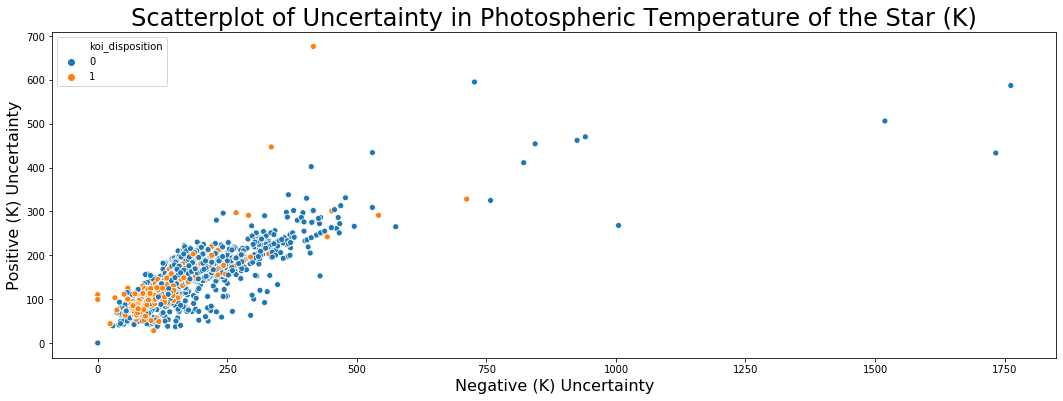

In [25]:
var = 'the negative poriton of the uncertainty of the photospheric temperature of the star'
top = df.koi_steff_err2.max()
bottom = df.koi_steff_err2.min()
print(f'The {var} ranges from an error of {top} to {bottom} Kelvin')

dude.graph_words(present_color)  
plt.figure(figsize=(18, 6))
sns.scatterplot(-1* df.koi_steff_err2, df.koi_steff_err1, hue=df.koi_disposition)

plt.xlabel('Negative (K) Uncertainty', fontsize=16)
plt.ylabel('Positive (K) Uncertainty', fontsize=16)

plt.title('Scatterplot of Uncertainty in Photospheric Temperature of the Star (K)',
         fontsize=24);
dude.graph_words('black')
plt.legend()
dude.graph_words(present_color)

It is hard to guess at why the range of uncertainty of the temperature of the surface of the star is strongly correlated to the disposition of the transiting object; ie why is that correlated with how sure we are about the presence of an exoplanet? 

It is possible that in areas of the the interstellar neighborhood where we are more certain of the Photospheric Temperature of the Star, we are also more certain that objects of interest that we observed in the Kepler project telescope are in fact exoplanets.

We can see that there is a definite cluster of values seen in the dataset, with the exoplanet class (1) clustering fairly well near the zero error.

***NEXT***<br>
The koi_slogg_err2 represents the base-10 logarithm of the acceleration due to gravity at the surface of the star.

The the base-10 logarithm of the acceleration due to gravity at the surface of the star ranges from an error of 0.0 to -1.007


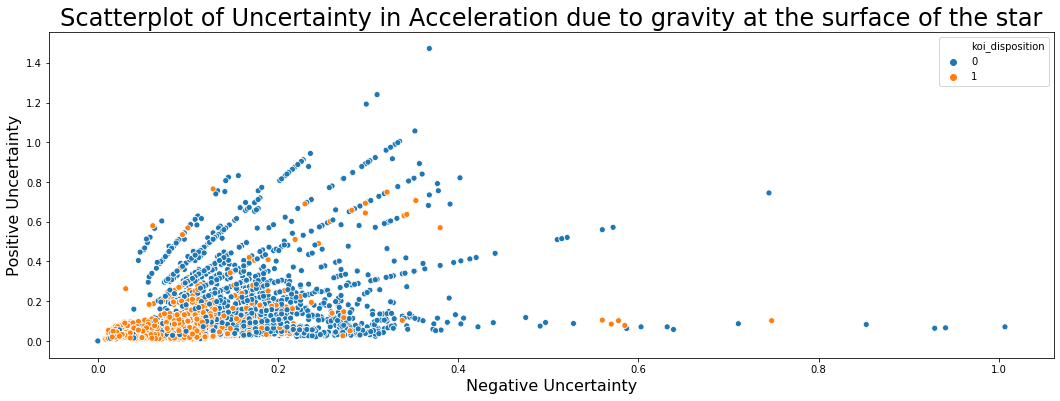

In [27]:
var = 'the base-10 logarithm of the acceleration due to gravity at the surface of the star'
top = df.koi_slogg_err2.max()
bottom = df.koi_slogg_err2.min()
print(f'The {var} ranges from an error of {top} to {bottom}')

dude.graph_words(present_color)
plt.figure(figsize=(18, 6))
sns.scatterplot(-1* df.koi_slogg_err2, df.koi_slogg_err1, hue=df.koi_disposition)

plt.xlabel('Negative Uncertainty', fontsize=16)
plt.ylabel('Positive Uncertainty', fontsize=16)


plt.title('Scatterplot of Uncertainty in Acceleration due to gravity at the surface of the star',
         fontsize=24);

dude.graph_words('black')
plt.legend();

Again we see an unmistakeable clustering of positive exoplanet designations around the zero error

***NEXT***<br>
The koi_duration_err2 is the negative uncertainty in the duration of the observed transits. According to the caltech KOI data dictionary, the Transit Duration is calculated in hours and found by using the "Mandel-Agol (2002) model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris"

The the uncertainty in the duration of the observed transits ranges from an error of 0.0 to -20.2


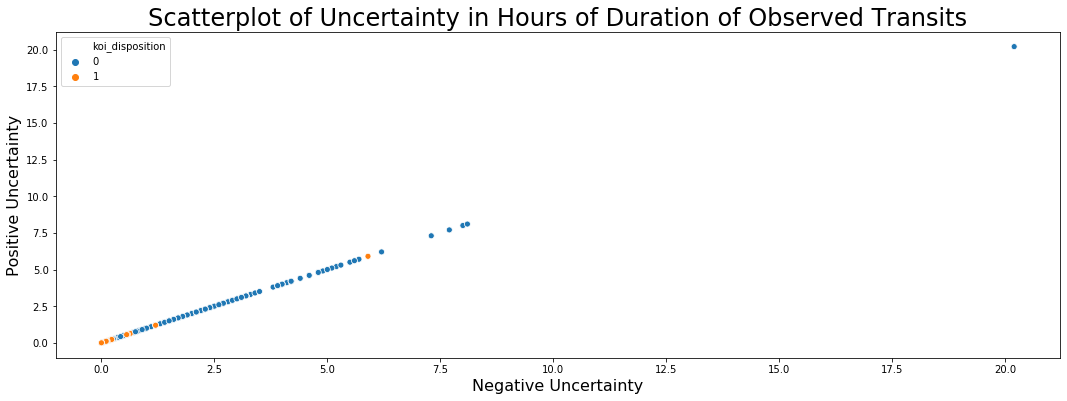

In [28]:
var = 'the uncertainty in the duration of the observed transits'
top = df.koi_duration_err2.max()
bottom = df.koi_duration_err2.min()
print(f'The {var} ranges from an error of {top} to {bottom}')

dude.graph_words(present_color)
plt.figure(figsize=(18, 6))
sns.scatterplot(-1* df.koi_duration_err2, df.koi_duration_err1, hue=df.koi_disposition)

plt.xlabel('Negative Uncertainty', fontsize=16)
plt.ylabel('Positive Uncertainty', fontsize=16)

plt.title('Scatterplot of Uncertainty in Hours of Duration of Observed Transits',
         fontsize=24);
dude.graph_words('black')
plt.legend();

## Certainty is...well, certain. 
It is intuitively obvious that for the above three measures, we are seeing that if we have more scientific certainty about the star, then any transits that we observe near that star that end up on the Kepler Objects of Interest table are inherently more certain as well. Thus, it stands to reason that there would be fewer observations that fit the criteria to end up on this list that end up being proved to be anomolies or errant entries.

***NEXT***<br>
Next we see that the koi_tce_plnt_num has a 27% positive correlation to the exoplanetary designation. This is certainly an anomoly as this column is the TCE Planet Number given to the object, and is not a measurement at all. We will drop this from the dataset.

In [29]:
df = df.drop(columns='koi_tce_plnt_num')

## Also Mentioned...
The koi_slogg measurement, again the Stellar Surface Gravity, measured as log base 10 centimeters per second squared, has a very weak but present positive correlation to the koi_disposition

The logarithm of Stellar Surface Gravity ranges from 5.283 to 0.047 log-base-10 centimeters per second squared


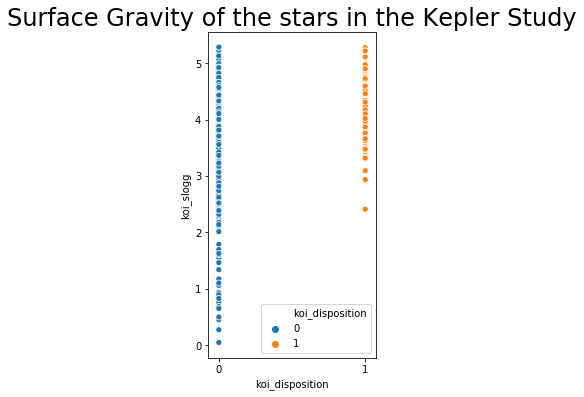

In [30]:
var = 'logarithm of Stellar Surface Gravity'
top = df.koi_slogg.max()
bottom = df.koi_slogg.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

dude.graph_words(present_color)
plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_slogg, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.title('Surface Gravity of the stars in the Kepler Study', fontsize=24)
dude.graph_words('black')
plt.legend();

This is, again, a very weak positive correlation, as we can see a lot of overlap in the classes, but clearly if the surface gravity is below 2.5 or so, we see there are no "confirmed" exoplanets.

## Look closely at the top five negatively correlated features

In [31]:
df.corr()['koi_disposition'].sort_values(ascending=True)[1:6]

koi_teq         -0.280370
koi_depth       -0.237222
koi_steff       -0.214034
koi_model_snr   -0.208750
ra              -0.189946
Name: koi_disposition, dtype: float64

In reverse order, we have the Right Ascension, which paired with the Declination helps us to map the star and our KOI observation in the sky; the Transit Signal-to-Noise ratio, the acutal Stellar Effective Temperature (measured in Kelvin), Transit Depth measured in parts per million, and the Equilibrium Temperature of the exoplanet (measured in Kelvin).

According to CalTech, the Transit Depth is "the fraction of stellar flux lost at the minimum of the planetary transit. Transit depths are typically computed from a best-fit model produced by a Mandel-Agol (2002) model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris."  

Quoting from that same data dictionary, the Equilibrium Temperature is the "Approximation for the temperature of the planet. The calculation of equilibrium temperature assumes a) thermodynamic equilibrium between the incident stellar flux and the radiated heat from the planet, b) a Bond albedo (the fraction of total power incident upon the planet scattered back into space) of 0.3, c) the planet and star are blackbodies, and d) the heat is evenly distributed between the day and night sides of the planet."

## Negative Correlations Graphed:

The Equilibrium Temperature ranges from 14667.0 to 92.0 log-base-10 centimeters per second squared


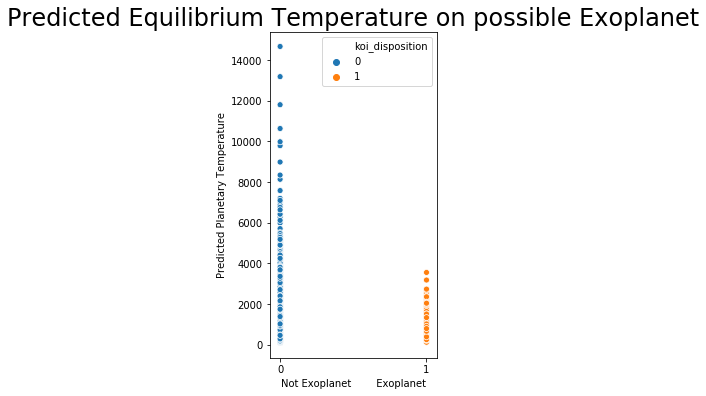

In [32]:
var = 'Equilibrium Temperature'
top = df.koi_teq.max()
bottom = df.koi_teq.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

dude.graph_words(present_color)
plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_teq, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.xlabel('Not Exoplanet        Exoplanet')
plt.ylabel('Predicted Planetary Temperature')
plt.title('Predicted Equilibrium Temperature on possible Exoplanet', fontsize=24)

dude.graph_words('black')
plt.legend();

We clearly see here that a predicted Equilibrium Planetary temperature has to be less than 4000 K to be classified as an exoplanet.

***NEXT***<br>
Next look at the Transit Depth

The Transit Depth ranges from 1540000.0 to 4.5 log-base-10 centimeters per second squared


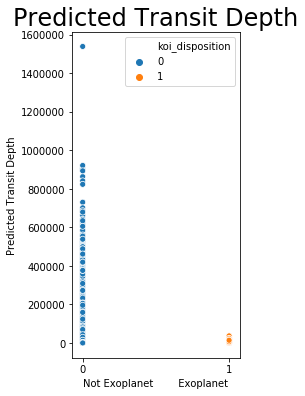

In [33]:
var = 'Transit Depth'
top = df.koi_depth.max()
bottom = df.koi_depth.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_depth, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.xlabel('Not Exoplanet        Exoplanet')
plt.ylabel('Predicted Transit Depth')
plt.title('Predicted Transit Depth', fontsize=24)
plt.legend();

Again we see all of the exoplanets cluster around the lower bound of Transit Depth

***NEXT***<br>
Stellar Effective Temperature

The Stellar Effective Temperature ranges from 15896.0 to 2661.0 log-base-10 centimeters per second squared


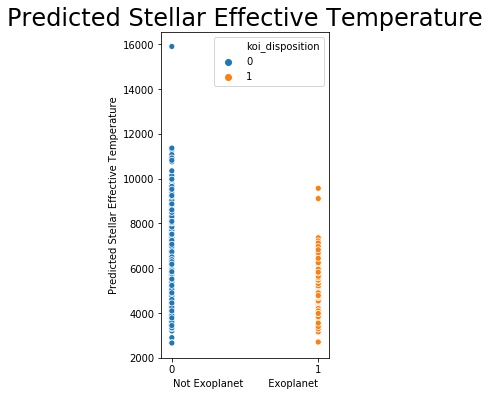

In [34]:
var = 'Stellar Effective Temperature'
top = df.koi_steff.max()
bottom = df.koi_steff.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

dude.graph_words(present_color)
plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_steff, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.xlabel('Not Exoplanet        Exoplanet')
plt.ylabel('Predicted Stellar Effective Temperature')
plt.title('Predicted Stellar Effective Temperature', fontsize=24)

dude.graph_words('black')
plt.legend();

The already-weak negative correlations are getting weaker as we can see a LOT of overlap in this chart too.

Given the absence of any very strong correlations, we've looked at some of the top weak correlations and can try to take the top ten features from these correlation tables and compare a confusion matrix of it to the original Logistic Regression model.

In [37]:
limited_features = list(df.corr()['koi_disposition'].sort_values(ascending=True)[0:5].keys())
for feat in list(df.corr()['koi_disposition'].sort_values(ascending=False)[1:6].keys()):
    limited_features.append(feat)
limited_features.append('koi_disposition')

In [38]:
limited_df = df[limited_features]

## Make our second Logistic Regression model, called lr2

In [39]:
lr2 = LogisticRegression()
X_lim_train, X_lim_train_sc, X_lim_val, X_lim_val_sc, y_lim_train, y_lim_val = dude.scaled_data_split(limited_df, 
                                                                                                      'koi_disposition')
lr2.fit(X_lim_train_sc, y_lim_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
print('Scores Comparrisson:')
print('*'*40)
print('smaller feature training score  :', lr2.score(X_lim_train_sc, y_lim_train))
print('Original Model training score   :', lr.score(X_train_sc, y_train))

print('smaller feature validation score:', lr2.score(X_lim_val_sc, y_lim_val))
print('Original Model validation score :', lr.score(X_val_sc, y_val))


Scores Comparrisson:
****************************************
smaller feature training score  : 0.8763223696864781
Original Model training score   : 0.9217157145604924
smaller feature validation score: 0.8692307692307693
Original Model validation score : 0.9207692307692308


In [41]:
y_pred = lr2.predict(X_lim_val_sc)
metrics.confusion_matrix(y_lim_val, y_pred, 
                         normalize=None)

array([[759,  84],
       [ 86, 371]], dtype=int64)

True Negatives: 759
False Negatives: 86

False Positives: 84
True Positives: 371
Sensitivity : 0.811816192560175
Specificity : 0.900355871886121


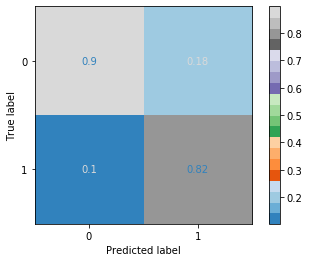

In [42]:
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_lim_val, y_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("False Positives: " + str(fp))
print("True Positives: " + str(tp))

sensitivity = tp / (tp+fn)
print(f'Sensitivity : {sensitivity}')
specificity = tn / (tn+fp)
print(f'Specificity : {specificity}')

dude.graph_words(present_color)
plot_confusion_matrix(lr2, X_lim_val_sc, y_lim_val, normalize='pred', cmap='tab20c');

Clearly, by limiting our field of features to only the 10 strongest correlated features, we only served to weaken our prediction engine AND to decrease our Sensitivity and Specificity. In other words, this more limited feature did not improve our predictions.

However we should keep in mind that while the results on the validation set might not have improved, our model may indeed be better equipped to handle data from a completely different data source, such as K2 or TESS data.

## Create lr3, a Logistic Regression using the original set minus the newly deleted columns

In [44]:
df.shape

(6499, 36)

training score:  0.9207539911521446
validation score:  0.9138461538461539


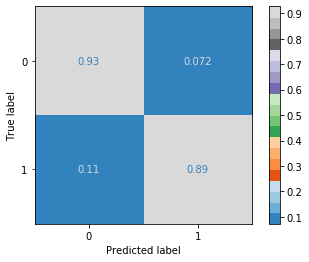

In [45]:
lr3 = LogisticRegression()
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(df, 'koi_disposition')
lr3.fit(X_train_sc, y_train)

print('training score: ', lr3.score(X_train_sc, y_train))
print('validation score: ', lr3.score(X_val_sc, y_val))
plot_confusion_matrix(lr3, X_val_sc, y_val, normalize='true', cmap='tab20c');

Still somehow this model is slightly more overfit versus the original, but it's likely that we were predicting on noise in that first model anyway, given that the deleted column was an ID number, so this is really a model that should perform better on unknown data.

In [46]:
# Show all columns used for this last model iteration
df.columns

Index(['koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

## Create a Random Forest Classifier
Random Forest Classifier employs a bagging process on a decision tree classifier, both bootstrapping (or resampling) and aggregating various decision trees to come up with the most likely predictions of the classes.

In [47]:
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(dataframe=df, target='koi_disposition')

In [48]:
rf = RandomForestClassifier()
rf.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
print('Training Score: ', rf.score(X_train_sc, y_train))
print('Validation Score: ', rf.score(X_val_sc, y_val))

Training Score:  1.0
Validation Score:  0.9361538461538461


It's still mind boggling that this RandomForestClassifier can be so accurate when there are no strong data correlations in the original dataset. We should look at the confusion matrix and see what we see.

In [50]:
y_pred = rf.predict(X_val_sc)

In [51]:
metrics.confusion_matrix(y_val, y_pred, 
                         normalize=None)

array([[806,  37],
       [ 46, 411]], dtype=int64)

In [52]:
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("False Positives: " + str(fp))
print("True Positives: " + str(tp))


True Negatives: 806
False Negatives: 46

False Positives: 37
True Positives: 411


In [53]:
sensitivity = tp / (tp+fn)
print(f'Sensitivity : {sensitivity}')
specificity = tn / (tn+fp)
print(f'Specificity : {specificity}')

Sensitivity : 0.899343544857768
Specificity : 0.9561091340450771


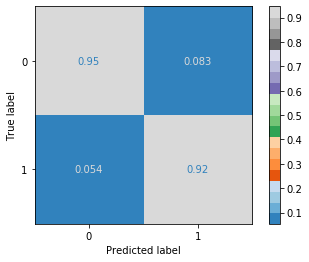

In [54]:
plot_confusion_matrix(rf, X_val_sc, y_val, normalize='pred', cmap='tab20c');

We can see that the model did a pretty good job at predicting our ground truth, with a Sensitivity of either 92%, or 90.4%, and a Specificity of 95.7%.

For the sake of assuredness, I can even weight these predictions when I'm more sure of the model, so that I have a lower number--even zero--of false positives. This way, I might miss some exoplanets, but I won't falsely predict any.

In [55]:
ss = StandardScaler()

Fit the candidates data to the Standard Scaler

In [56]:
candidates = candidates[list(df.columns)]

In [57]:
test = candidates.drop(columns='koi_disposition')

In [58]:
ss.fit(X_train)
test_sc = ss.transform(test)

In [59]:
candidates['exoplanet'] = rf.predict(test_sc)

In [60]:
candidates.exoplanet.value_counts()

0    1450
1     795
Name: exoplanet, dtype: int64

If this model is predicting accurately, we have just identified about 715 new exoplanets, given that our model predicted 795 out of 2245 observations to be exoplanets and has a sensitivity of aobut 90%

## Create a Recurrent Neural Network
Using a neural network on such a small dataset is thought to be a waste of computing power. Charles Rice, Data Scientist with General Assembly, said something to the effect of this action being akin to using "a sandblaster to cut a salt cracker." That being said, it does help to reinforce the unexpectedly accurate results that we see in the Random Forest Classifier.

In [61]:
X_train_sc.shape

(5199, 35)

In [62]:
# Use the same RNN that we built prior as a "baseline", 
# but change the first layer to have the same number of 
# nodes as input features

rnn = Sequential()
rnn.add(Dense(35, input_dim=X_train.shape[1], activation='relu'))
rnn.add(Dense(16, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc']) # loss = 'bce'

history_rnn = rnn.fit(
    X_train_sc,
    y_train,
    validation_data=(X_val_sc, y_val),
    epochs=100,
    batch_size=None,
    verbose=2
)

Epoch 1/100
163/163 - 1s - loss: 0.4454 - acc: 0.8155 - val_loss: 0.3112 - val_acc: 0.8715
Epoch 2/100
163/163 - 0s - loss: 0.2787 - acc: 0.8936 - val_loss: 0.2464 - val_acc: 0.8977
Epoch 3/100
163/163 - 0s - loss: 0.2339 - acc: 0.9123 - val_loss: 0.2258 - val_acc: 0.9138
Epoch 4/100
163/163 - 0s - loss: 0.2122 - acc: 0.9208 - val_loss: 0.2152 - val_acc: 0.9154
Epoch 5/100
163/163 - 0s - loss: 0.1995 - acc: 0.9221 - val_loss: 0.2049 - val_acc: 0.9231
Epoch 6/100
163/163 - 0s - loss: 0.1881 - acc: 0.9284 - val_loss: 0.2014 - val_acc: 0.9285
Epoch 7/100
163/163 - 0s - loss: 0.1801 - acc: 0.9354 - val_loss: 0.1978 - val_acc: 0.9323
Epoch 8/100
163/163 - 0s - loss: 0.1754 - acc: 0.9359 - val_loss: 0.1897 - val_acc: 0.9300
Epoch 9/100
163/163 - 0s - loss: 0.1681 - acc: 0.9383 - val_loss: 0.1882 - val_acc: 0.9292
Epoch 10/100
163/163 - 0s - loss: 0.1645 - acc: 0.9377 - val_loss: 0.1904 - val_acc: 0.9315
Epoch 11/100
163/163 - 0s - loss: 0.1611 - acc: 0.9396 - val_loss: 0.1822 - val_acc: 0.93

Epoch 91/100
163/163 - 0s - loss: 0.0776 - acc: 0.9721 - val_loss: 0.1591 - val_acc: 0.9492
Epoch 92/100
163/163 - 0s - loss: 0.0783 - acc: 0.9706 - val_loss: 0.1601 - val_acc: 0.9492
Epoch 93/100
163/163 - 0s - loss: 0.0784 - acc: 0.9715 - val_loss: 0.1637 - val_acc: 0.9492
Epoch 94/100
163/163 - 0s - loss: 0.0759 - acc: 0.9736 - val_loss: 0.1650 - val_acc: 0.9462
Epoch 95/100
163/163 - 0s - loss: 0.0765 - acc: 0.9736 - val_loss: 0.1618 - val_acc: 0.9477
Epoch 96/100
163/163 - 0s - loss: 0.0761 - acc: 0.9715 - val_loss: 0.1594 - val_acc: 0.9515
Epoch 97/100
163/163 - 0s - loss: 0.0771 - acc: 0.9704 - val_loss: 0.1626 - val_acc: 0.9492
Epoch 98/100
163/163 - 0s - loss: 0.0755 - acc: 0.9733 - val_loss: 0.1638 - val_acc: 0.9492
Epoch 99/100
163/163 - 0s - loss: 0.0759 - acc: 0.9721 - val_loss: 0.1662 - val_acc: 0.9454
Epoch 100/100
163/163 - 0s - loss: 0.0759 - acc: 0.9736 - val_loss: 0.1666 - val_acc: 0.9477


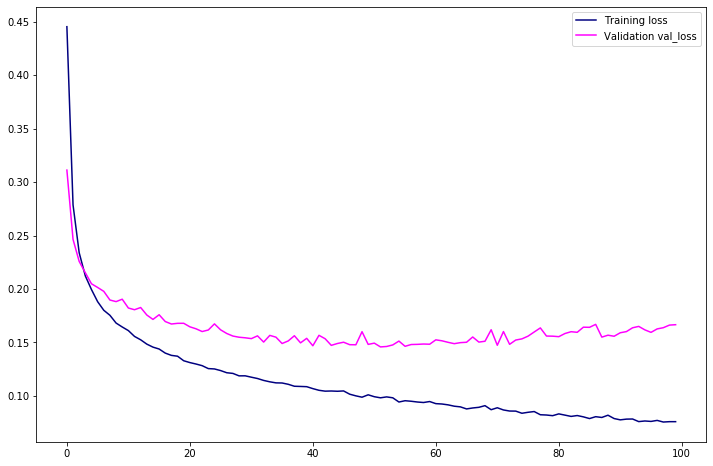

In [63]:
dude.display_metrics(history_rnn, 'loss')


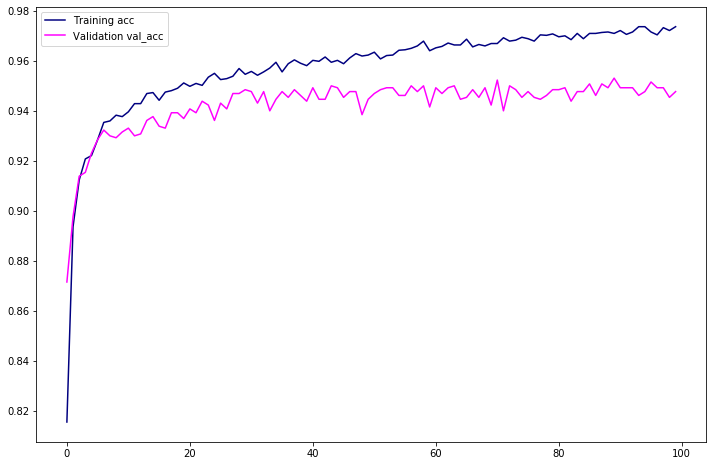

In [64]:
dude.graph_words(present_color)
dude.display_metrics(history_rnn, 'acc')

In [65]:
model_rnn_top_score = sorted(history_rnn.history['val_acc'], reverse=True)[0]
print(f'This model has a maximum accuracy score of {model_rnn_top_score}')

model_rnn_best_loss = sorted(history_rnn.history['val_loss'], reverse=False)[0]
print(f'This model has a minimum loss score of {model_rnn_best_loss}')

This model has a maximum accuracy score of 0.9530768990516663
This model has a minimum loss score of 0.14580610394477844


It looks like the Recurrent Neural Network Model performs best at around epoch 30, and starts to get not so great around epoch 75. We also make a confusion matrix with the RNN results, but we don't have the same graphing option as we would in the scikit-learn models.

In [66]:
y_rnn_pred = rnn.predict_classes(X_val_sc)
metrics.confusion_matrix(y_val, y_rnn_pred, 
                         normalize=None)
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_rnn_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))
print("False Positives: " + str(fp))
print("\n*************************\n")
sensitivity_rnn = tp / (tp+fn)
print(f'RNN Sensitivity : {sensitivity_rnn}')
#print(f'RFC Sensitivity : {sensitivity}')
specificity_rnn = tn / (tn+fp)
print(f'RNN Specificity : {specificity_rnn}')
#print(f'RFC Specificity : {specificity}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
True Negatives: 808
False Negatives: 33

True Positives: 424
False Positives: 35

*************************

RNN Sensitivity : 0.9277899343544858
RNN Specificity : 0.9584816132858838


We see that the two models preform nearly the same on both Sensitivity and Specificity.  This is a good indicator of an accurate model.

In [67]:
candidates['exoplanet_rnn'] = rnn.predict_classes(test_sc)

In [68]:
candidates['exoplanet_rnn'].value_counts()

0    1342
1     903
Name: exoplanet_rnn, dtype: int64

So now we have two models using the same data, with slightly different Accuracy Scores, predicting a similar number of exoplanets. The next step will be to see which observations are predicted by both models.

In [69]:
overlap = candidates[['exoplanet', 'exoplanet_rnn']][(candidates['exoplanet']==1) | (candidates['exoplanet_rnn']==1)]
overlap.shape

(1007, 2)

In [70]:
overlap[(overlap.exoplanet == 1) & (overlap.exoplanet_rnn == 1)]

,exoplanet,exoplanet_rnn
kepid,,
6043538,1,1
4048898,1,1
11288772,1,1
10659624,1,1
10450504,1,1
...,...,...
8456679,1,1
7941200,1,1
7199397,1,1


## Add Predictions from the Logistic Regression model

In [71]:
candidates['exoplanet_lr3'] = lr3.predict(test_sc)
candidates['exoplanet_lr3'].value_counts()

0    1216
1    1029
Name: exoplanet_lr3, dtype: int64

We can now add this to the overlap table

In [72]:
overlap = candidates[['exoplanet', 'exoplanet_rnn', 'exoplanet_lr3']][(candidates['exoplanet']==1) | (candidates['exoplanet_rnn']==1) | (candidates['exoplanet_lr3']==1)]
overlap.shape

(1194, 3)

In [73]:
new_exoplanets = overlap[(overlap.exoplanet == 1) & (overlap.exoplanet_rnn == 1) & (overlap.exoplanet_lr3 == 1)]

In [74]:
new_exoplanets.shape

(661, 3)

## New results?
**We just ran three fairly accurate prediction models against a list of 2245 unclassified Kepler Objects of Interest, and have confidently found that 661 of these observations are predicted to be exoplanets in all three! I would like to adjust the probability threshold and try to eliminate false positives from the predictions that are made on the validation set, and then re-run the test to see how many exoplanets are then predicted, but for now this is a fairly confident model and should be put in to a python program for use.**

**We can additionaly look at the overlap between our confusion matricies, or in other words, we can see where each model predicted correctly against the ground truth and where the false-positives were. This can give us some insight in to what the model was misreading.**

**The next step is to start running the various other KOI dataset experiments, such as a Convoultional Neural Network on the time-series dataset, and seeing if the kepid's are the same accross our predictive results from the unknown Candidates. Then I will make confident predictions.**

## Factor in the probabilities where possible

Classification models such as Logistic Regression and Random Forest Classifier are able to tell us the probabilities that each row is or is not an exoplanet. Typically it uses this probability to make its prediction, with a probability above 50% being an exoplanet, and one below 50% being not an exoplanet. We can create a function to adjust the predictions and see if that can eliminate false positives from our predictive models.

We can also create an overlap table using the Validation data in each of the three models and see how many false positives are predicted that way. Finally, we can try using GridSearch or creating a larger ensemble model as well, and see how that affects our false positive rate.

## Conclusion:

We still need to take a look at how we can limit our predictions further, but as of now, we can be fairly confident that we have identified about 595 or more exoplanets given that our overlapping models agree on 661 of them with a 90% Sensitivity on two out of three models. 